In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stat
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score

In [2]:
warnings.filterwarnings('ignore') # to supress warnings

In [3]:
sns.set()

## **Recap: We want to create a model to predict Expected Loss (EL).**

---

### 💰 Expected Loss (EL) is defined as the estimated amount a lender may lose by lending to a borrower.

#### 💡 Formula

$$
EL = PD \times LGD \times EAD
$$

**Where:**

- **EL** = Expected Loss  
- **PD** = **Probability of Default** is commonly estimated using **logistic regression**, since it is a binary outcome (default (say represented using 0) or no default (say represented using 1)).  
- **Loss Given Default (LGD)** and **Exposure at Default (EAD)** are typically estimated using **regression techniques**, such as **beta regression**, **linear regression**, or **Tobit models**, depending on the data characteristics.

---

### Logistic regression for PD is well-established.

- LGD and EAD require continuous outcome models, beta regression is used especially when outcomes are proportions (0 to 1).

---

# 📈 Logistic Regression: 

## Logistic Regression models the probability that a given input point belongs to a particular class using the logistic (sigmoid) function.


<img src="logistic_regression.jpg" alt="alt text" width="500" />


## Logistic Regression: Mathematical Formulation

In logistic regression, the dependent variable $Y$ is binary (0 or 1), and we model the **log-odds** (logit) of $Y=1$ as a linear function of the predictors.

### **Logit Model**


### $\text{logit}(p) = \ln\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_k X_k$


#### Where:
- $p = P(Y=1 \mid X_1, X_2, \dots, X_k)$
- $\beta_0$ is the intercept
- $\beta_i$ are the coefficients for predictors $X_i$

---

### **Logistic (Sigmoid) Function**
The probability $p$ can be obtained from the logit as:


### $P(Y=1|X) = \frac{1}{1 + e^{-$beta_0 + \beta_1 X_1 + \dots + \beta_k X_k)}}$

#### or equivalently:

### $P(Y=1|X) = \frac{e^{\beta_0 + \beta_1 X_1 + \dots + \beta_k X_k}}{1 + e^{\beta_0 + \beta_1 X_1 + \dots + \beta_k X_k}}$


#### Where:
- $P(Y=1|X)$ is the probability that the output $(Y)$ is 1 given predictors $(X)$
- $\beta_0$ is the intercept (bias)
- $\beta_1, \beta_2, \ldots, \beta_n$ are the coefficients for each feature

---

### **Odds and Odds Ratio**

#### The **odds** of $Y=1$ are:

### $\text{Odds} = \frac{p}{1-p} = e^{\beta_0 + \beta_1 X_1 + \dots + \beta_k X_k}$

#### An increase of 1 unit in $X_j$ changes the odds by a factor of $e^{\beta_j}$ (odds ratio).

---

## 🧠 Key Characteristics

- **Dependent variable** must be **binary** (e.g., 0 or 1).
- **Independent variables** can be continuous, categorical (encoded), or mix of continuous and categorical.
- Outputs **probabilities** between 0 and 1.
- Often used for **classification** tasks such as spam detection, credit default prediction, etc.

---

## ✅ Assumptions

- The outcome is binary.
- Observations are independent.
- There is **little to no multicollinearity** among predictors.
- The model uses the **log-odds** of the outcome as a linear function of the predictors.

---

In [4]:
train_input = pd.read_csv('dataset/train_input2.csv') # independent variables for training.
test_input = pd.read_csv('dataset/test_input2.csv') # # independent variables for testing.

train_output = pd.read_csv('dataset/train_output.csv') # target variables for training.
test_output = pd.read_csv('dataset/test_output.csv') # target variables for testing.

In [5]:
len(train_input), len(train_input.keys())

(1808534, 397)

In [6]:
len(test_input), len(test_input.keys())

(452134, 397)

### Note: We have 397 columns in our training and testing dataset. However, we won't be using all of these columns for our PD model. 

In [7]:
# List of independent variables.

ind_var_lst = ['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F', 'grade:G',
                     
                    'home_ownership:OWN', 'home_ownership:MORTGAGE', 'home_ownership:Rent_Any_None_Other',
                     
                    'addr_state:NC_MD_MO_IN_PA_NJ', 'addr_state:KS_WA_CT_SC_CO_ND', 'addr_state:IA_AL_MS_AR_OK_LA_NV',
                    'addr_state:GA_WY_RI_MT_IL', 'addr_state:AK_MA_DE_UT_WI', 'addr_state:TN_MI_VA_KY_AZ', 
                    'addr_state:OR_NH_WV_DC', 'addr_state:HI_NM_SD', 'addr_state:MN_NE_OH', 'addr_state:ID_VT',
                    'addr_state:TX', 'addr_state:CA', 'addr_state:FL', 'addr_state:NY', 'addr_state:ME',
                     
                    'verification_status:Verified_SourceVerified', 'verification_status:Not Verified', 
                     'verification_status:Verified_SourceVerified',
                     
                    "initial_list_status:w", "initial_list_status:f",
                     
                    "term_int:36", "term_int:60",
                     
                    "emp_length_int:2_3_4_5_6", 'emp_length_int:1_7_9', 'emp_length_int:10', "emp_length_int:0_8",
                     
                    'purpose:renewable_energy_moving', 'purpose:wedding_house_vacation', 'purpose:educational_small_business',
                    'purpose:debt_consolidation', 'purpose:other', 'purpose:medical', 'purpose:credit_card',
                    'purpose:major_purchase', 'purpose:home_improvement', 'purpose:car',
                     
                    'months_since_issue_date:<83', 'months_since_issue_date:83-86', 'months_since_issue_date:86-89',
                    'months_since_issue_date:89-91', 'months_since_issue_date:91-94', 'months_since_issue_date:94-97',
                    'months_since_issue_date:97-99', 'months_since_issue_date:99-102', 'months_since_issue_date:102-105',
                    'months_since_issue_date:105-108', 'months_since_issue_date:108-138', 'months_since_issue_date:138-160',
                    'months_since_issue_date:>160',
                     
                    'int_rate:<7.878', 'int_rate:7.878-8.392', 'int_rate:8.392-10.96', 'int_rate:10.96-11.987',
                    'int_rate:11.987-13.014', 'int_rate:13.014-15.068', 'int_rate:15.068-17.123',
                    'int_rate:17.123-22.772', 'int_rate:22.772-26.368', 'int_rate:>26.368',
                     
                     
                     "mths_since_last_delinq:5-9", "mths_since_last_delinq:9-18",
                     "mths_since_last_delinq:18-32", "mths_since_last_delinq:32-50", "mths_since_last_delinq:50-72",
                     "mths_since_last_delinq:>72", "mths_since_last_delinq:<5",

                     "dti:<3", "dti:3-6", "dti:6-9", "dti:9-12", "dti:12-15", "dti:15-18", "dti:18-21", "dti:21-23",
                     "dti:23-26", "dti:26-30", "dti:30-35", "dti:>35",

                     "annual_inc:24000-36000", "annual_inc:36000-48000", "annual_inc:48000-60000", "annual_inc:<24000",
                     "annual_inc:60000-72000", "annual_inc:72000-88000", "annual_inc:88000-100000", "annual_inc:100000-116000",
                     "annual_inc:116000-128000", "annual_inc:128000-152000", "annual_inc:152000-200000",

                     'pub_rec:0', 'pub_rec:1', 'pub_rec:>1',
                     
                     'inq_last_6mths:0', 'inq_last_6mths:1', 'inq_last_6mths:2', 'inq_last_6mths:>2',

                     "total_acc:<14.08", "total_acc:14.08-21.12", "total_acc:21.12-31.68", 
                     "total_acc:31.68-42.24", "total_acc:>42.24", 
                     
                    "installment:<142", "installment:142-245", "installment:245-348", "installment:348-451", "installment:451-588",
                    "installment:588-725", "installment:725-897", "installment:897-1000", "installment:>1000",
                     
                    'funded_amnt:<1290', 'funded_amnt:1290-2080', 'funded_amnt:2080-2870', 'funded_amnt:2870-6030',
                    'funded_amnt:6030-9190', 'funded_amnt:9190-35260', 'funded_amnt:>35260', 'funded_amnt:9190-35260',]

In [8]:
# List of reference variables.
ref_var_lst =  ['grade:G', 'home_ownership:Rent_Any_None_Other', 'addr_state:IA_AL_MS_AR_OK_LA_NV',
            'verification_status:Verified_SourceVerified', "initial_list_status:f", "term_int:60",
            "emp_length_int:0_8", 'purpose:educational_small_business', 'months_since_issue_date:>160',
            'int_rate:>26.368', 'funded_amnt:9190-35260', "mths_since_last_delinq:<5", "dti:>35",
            "annual_inc:<24000", 'pub_rec:>1', 'inq_last_6mths:>2', "installment:>1000", "total_acc:>42.24"]

In [9]:
train_var = train_input.loc[:, ind_var_lst]
test_var = test_input.loc[:, ind_var_lst]

train_var = train_var.astype(int)
test_var = test_var.astype(int)

pd_train_input = train_var.drop(ref_var_lst, axis = 1)
pd_test_input = test_var.drop(ref_var_lst, axis = 1)

pd_train_input.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NC_MD_MO_IN_PA_NJ,addr_state:KS_WA_CT_SC_CO_ND,...,installment:451-588,installment:588-725,installment:725-897,installment:897-1000,funded_amnt:<1290,funded_amnt:1290-2080,funded_amnt:2080-2870,funded_amnt:2870-6030,funded_amnt:6030-9190,funded_amnt:>35260
0,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
feature_names = pd_train_input.columns.values # Getting the name of all columns

### **Logistic regression**

In [11]:
reg = LogisticRegression() # creating an object for our model.

In [12]:
pd.options.display.max_rows = None

In [13]:
reg.fit(pd_train_input, train_output)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [14]:
summary_table1 = pd.DataFrame(columns = ['Feature Names'], data = feature_names)
summary_table1['Coefficients'] = np.transpose(reg.coef_)
summary_table1.index = summary_table1.index + 1
summary_table1.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table1 = summary_table1.sort_index()
summary_table1.head()

,Feature Names,Coefficients
0,Intercept,-0.961358
1,grade:A,1.226053
2,grade:B,1.027917
3,grade:C,0.803986
4,grade:D,0.621926


### **P-Values and Significance Testing in Logistic Regression**

### 1. What is a p-value?

#### In logistic regression, a **p-value** measures the probability of obtaining a coefficient estimate at least as extreme as the one observed, **assuming the null hypothesis is true**.  

The null hypothesis for each coefficient is:

$H_0: \beta_i = 0$

$H_1: \beta_i \neq 0$

Where:
- $\beta_i$ = coefficient for the predictor $X_i$
- $H_0$ = predictor has no effect on the log-odds (relationship is not statistically significant)
- $H_1$ = predictor has a significant effect on the log-odds

A **low p-value** (typically < 0.05) indicates that we can reject $H_0$ and conclude that the variable is statistically significant.

---

### 2. Significance testing for variables
- **Significant variable (p-value < 0.05)** → The predictor is likely associated with the outcome after controlling for other predictors.
- **Insignificant variable (p-value ≥ 0.05)** → The evidence is insufficient to claim an association.

---

### 3. Special note on dummy variables
When categorical variables are one-hot encoded into dummy variables:
- One category is omitted (reference category) to avoid the **dummy variable trap** (perfect multicollinearity).
- Each dummy’s coefficient measures the change in log-odds **relative to the reference category**.
- P-values for individual dummies test whether each category differs significantly from the reference category.

---

### 4. Keep or remove variables?
- In **scorecard or risk modeling**, we often test significance **for the variable as a whole**, not just individual dummies.
    - If the variable overall is significant → keep all its dummies.
    - If the variable overall is insignificant → drop the entire variable.
- In **predictive modeling**, feature selection may use:
    - p-value thresholding
    - regularization methods (e.g., Lasso) to remove weak predictors.

---

**Key takeaway:**  
P-values help determine whether predictors are statistically significant in logistic regression.  
For categorical predictors, test significance at the **variable level** to preserve interpretability and avoid bias caused by selectively removing dummies.

---

#### Note:- LogisticRegression from scikit-learn does not provide `p-values` or statistical inference outputs like  `t-statistics`, or `confidence intervals`. Therefore, we need to calculate them separately.

In [15]:
class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [16]:
reg2 = LogisticRegression_with_p_values() # creating an object for our model.
reg2.fit(pd_train_input, train_output)

In [17]:
summary_table2 = pd.DataFrame(columns = ['Feature Names'], data = feature_names)
summary_table2['Coefficients'] = np.transpose(reg.coef_)
summary_table2.index = summary_table2.index + 1
summary_table2.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table2 = summary_table2.sort_index()

In [18]:
p_values = reg2.p_values
p_values = np.append(np.nan, np.array(p_values))
summary_table2['p_values'] = p_values
summary_table2.head()

,Feature Names,Coefficients,p_values
0,Intercept,-0.961358,NaN
1,grade:A,1.226053,1.021728e-199
2,grade:B,1.027917,8.494995e-186
3,grade:C,0.803986,2.829222e-139
4,grade:D,0.621926,5.128737e-101


In [19]:
# Checking insignificant variables, with CI of 95%
for idx, pval in enumerate(summary_table2['p_values']):
    if pd.isnull(pval):  # check for NaN
        continue
    if pval > 0.05:
        print(summary_table2.loc[idx, 'Feature Names'])

mths_since_last_delinq:32-50
dti:<3
dti:18-21
annual_inc:60000-72000
pub_rec:1
installment:897-1000
funded_amnt:>35260


---
### Interpretation of Coefficients in the PD Logistic Regression Model

In this model, the **worst categories** of each variable are used as the **reference group**. The dependent variable is binary, where:

- **0** = Default (worst outcome)  
- **1** = No default (better outcome)

Because of this encoding and reference choice, the logistic regression coefficients represent the log-odds of a borrower **being a non-default** relative to the worst category.

**Key points for interpretation:**

- A **positive coefficient** indicates that moving from the worst category (reference) to a better category **increases the log-odds of no default**, i.e., it decreases the probability of default.
- An **odds ratio (OR) > 1**, calculated as $(e^{\beta}$), means the odds of no default increase compared to the worst category.
- Conversely, a **negative coefficient** corresponds to an odds ratio less than 1, indicating a decrease in the odds of no default relative to the worst category.


#### Example: Interpretation of `grade` variable coefficients

| Grade Category | Coefficient | Odds Ratio $(e^{{\beta}})$ |
|----------------|-------------|-------------------------------|
| A (best)       | 1.221187    | $(e^{1.221187}$ approx $3.39$) |
| B              | 1.016422    | $(e^{1.016422}$ approx $2.76$) |
| C              | 0.781822    | $(e^{0.781822}$ approx $2.19$) |
| D              | 0.593793    |  $(e^{0.593793}$ approx $1.81$)|
| E              | 0.381067    | $(e^{0.381067}$ approx $1.46$) |
| F (worst)      | 0.198114    | $(e^{0.198114}$ approx $1.22$) |

---

**Interpretation:**

- Since the worst grade (e.g., Grade G or some baseline worst category) is the reference, these coefficients show the effect of being in each grade category **compared to the worst**.
- For instance, a borrower with **Grade A** has a coefficient of **1.22**, meaning the **log-odds of no default are 1.22 higher** than a borrower in the worst grade.
- The odds ratio $(e^{1.22}$ approx $3.39)$ means borrowers with Grade A have **3.39 times higher odds of not defaulting** compared to the worst grade.
- Similarly, Grade B borrowers have 2.76 times higher odds of no default than the worst grade, and so on.
- All p-values are extremely small, indicating these effects are statistically significant.

---

### Comparing Odds Between Any Two Grades

To compare the odds of no default **between any two grades**, say Grade X and Grade Y:

1. Calculate the difference in coefficients:

$\Delta = \beta_{X} - \beta_{Y}$

2. Calculate the odds ratio for no default between Grade X and Grade Y as:

### $\text{Odds}(\frac{X}{Y}) = e^{\Delta}$ = $e^{\beta_{X} - \beta_{Y}}$

---

**Example:**

Compare Grade A to Grade C:

$\Delta = 1.221187 - 0.781822 = 0.439365$

### $\text{Odds}(\frac{A}{C}) = e^{0.439365} \approx 1.55$

This means borrowers with Grade A have **1.55 times higher odds of no default** than those with Grade C.

**Note:- Direct comparisons are possible only between categories comming from the same variable.**

**Summary:** Since the worst categories are the baseline and the dependent variable coding has "no default" as 1, **higher positive coefficients indicate better borrower profiles with lower default risk.**

---

### Now, we'll use our test data to validate our model.

In [20]:
pd_test_input.head() # it has the same variables as the training data.

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NC_MD_MO_IN_PA_NJ,addr_state:KS_WA_CT_SC_CO_ND,...,installment:451-588,installment:588-725,installment:725-897,installment:897-1000,funded_amnt:<1290,funded_amnt:1290-2080,funded_amnt:2080-2870,funded_amnt:2870-6030,funded_amnt:6030-9190,funded_amnt:>35260
0,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Probability Cut-off in Logistic Regression

Logistic regression outputs **predicted probabilities** of the positive class (in our case: `no default = 1`, `default = 0`).

#### Default Cut-off in scikit-learn
- By default, scikit-learn’s `LogisticRegression` uses **0.5** as the decision threshold.
- This means:
  - If `P(no default) ≥ 0.5`, classify as **no default**.
  - If `P(no default) < 0.5`, classify as **default**.
- With our coding (`no default = 1`), a 0.5 cut-off implies the model predicts **default** only when it is more than 50% confident in that outcome.

In [21]:
# making predictions
pred_labels = reg2.model.predict(pd_test_input)

# pred_labels is an array with labels 0 and 1, which are derived using a cut-off of 50% on the predicted probability from the logistic regression.
pred_labels[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Changing the Cut-off: The cut-off can be adjusted to suit business needs (e.g., being more conservative to catch risky borrowers).

- Example: Using custom threshold, e.g., 0.3 instead of 0.5.

- To adjust the threshold, it is recommended to examine the predicted probabilities from the logistic regression model rather than relying solely on the default 0.5 cut-off.

In [22]:
pred_prob = reg2.model.predict_proba(pd_test_input)
pred_prob[:10] # is an array of arrays containing predicted probabilities. 
# The first element is the Probability of Default (0) and the second is Probability of no Default (1).

array([[0.18944765, 0.81055235],
       [0.10246075, 0.89753925],
       [0.33625285, 0.66374715],
       [0.07722409, 0.92277591],
       [0.10663151, 0.89336849],
       [0.26232533, 0.73767467],
       [0.31045182, 0.68954818],
       [0.09394556, 0.90605444],
       [0.25693663, 0.74306337],
       [0.22580341, 0.77419659]])

In [23]:
pred_prob_no_default = pred_prob[:][:, 1]
pred_prob_no_default

array([0.81055235, 0.89753925, 0.66374715, ..., 0.97662799, 0.73472539,
       0.87235537], shape=(452134,))

In [24]:
df_true_pred_prob = pd.concat([test_output, pd.DataFrame(pred_prob_no_default)], axis = 1)
df_true_pred_prob.columns = ['testdata_true_class', 'pred_prob']
df_true_pred_prob.shape

(452134, 2)

In [25]:
df_true_pred_prob.head()

,testdata_true_class,pred_prob
0,1,0.810552
1,1,0.897539
2,1,0.663747
3,1,0.922776
4,1,0.893368


## **Evaluating our model**

### Confusion Matrix and Classification Metrics

A **confusion matrix** summarizes the performance of a classification model by comparing predicted labels with actual outcomes.

|                  | **Predicted No Default (1)** | **Predicted Default (0)** |
|------------------|-----------------------------|----------------------------|
| **Actual No Default (1)** | True Positive (TP)          | False Negative (FN)         |
| **Actual Default (0)**    | False Positive (FP)         | True Negative (TN)          |

---

#### Key Metrics

1. **Accuracy**  
   Proportion of correct predictions out of all predictions.  
   
   $\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$

2. **Precision (Positive Predictive Value)**  
   Of all borrowers predicted as **no default**, how many actually did not default?  
   
   $\text{Precision} = \frac{TP}{TP + FP}$

4. **Recall (Sensitivity / True Positive Rate)**  
   Of all actual **no defaults**, how many did we correctly identify?  

   $\text{Recall} = \frac{TP}{TP + FN}$


6. **Specificity (True Negative Rate)**  
   Of all actual **defaults**, how many did we correctly flag as default?

   
   $\text{Specificity} = \frac{TN}{TN + FP}$

8. **F1-Score**  
   Harmonic mean of precision and recall.

   
   $\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

---

### How to Interpret High/Low Metric Values

- **High Accuracy** → The model is making correct predictions most of the time.  
  *Caution:* In imbalanced datasets (e.g., defaults are rare), high accuracy can be misleading if the model is mostly predicting the majority class.

- **High Precision (for no-default)** → When the model predicts **no default**, it is usually correct.  
  *Useful when the cost of wrongly approving a risky borrower (False Positive) is high.*

- **High Recall (for no-default)** → The model is good at finding most of the actual **no defaults**.  
  *Useful when you want to maximize approvals of safe borrowers.*

- **High Recall (for default)** → The model is good at identifying most risky borrowers.  
  *Important when you want to minimize missed defaults (False Negatives).*

- **High Specificity** → The model correctly flags most actual defaults.  
  *Good for risk-averse strategies where missing a default is very costly.*

- **High F1-Score** → The model has a good balance between precision and recall.  
  *Useful when both False Positives and False Negatives are costly.*

- **Low Precision** → Many of the predicted no-defaults are actually defaults (more False Positives).  
- **Low Recall** → The model is missing many true cases of the class in question (more False Negatives).


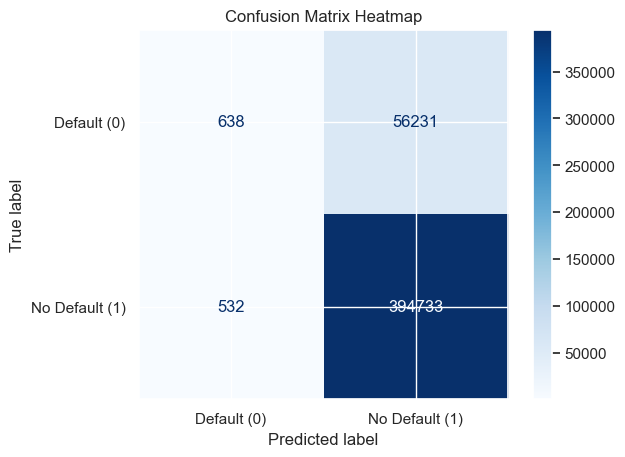

Accuracy: 0.8744553605789435
Precision: 0.875309337330696
Recall: 0.9986540675243192
F1 Score: 0.9329224122548389
Specificity: 0.011218765935747067


In [26]:
cutoff_threshold = 0.5 ## Starting with the default cut-off threshold of 50 %.
df_true_pred_prob['testdata_pred_class'] = np.where(df_true_pred_prob['pred_prob'] > cutoff_threshold, 1, 0)


y_test = df_true_pred_prob['testdata_true_class']
y_pred = df_true_pred_prob['testdata_pred_class']


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Default (0)", "No Default (1)"])


# Plot heatmap
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix Heatmap")
plt.show()

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Specificity:", cm[0][0]/cm[0].sum())

### Interpretation

- High recall for no-default (99.87%) → The model catches almost every borrower who will not default.

- Moderate precision for no-default (87.5%) → About 12.5% of approved borrowers (predicted no-default) are actually defaults.

- Very low specificity for default (1.06%) → The model almost never correctly flags defaults, **it lets most risky borrowers pass as no-default.**

- **Business impact, the model is very lenient, approving almost everyone, which minimizes rejecting good borrowers but severely increases the risk of approving defaults.**

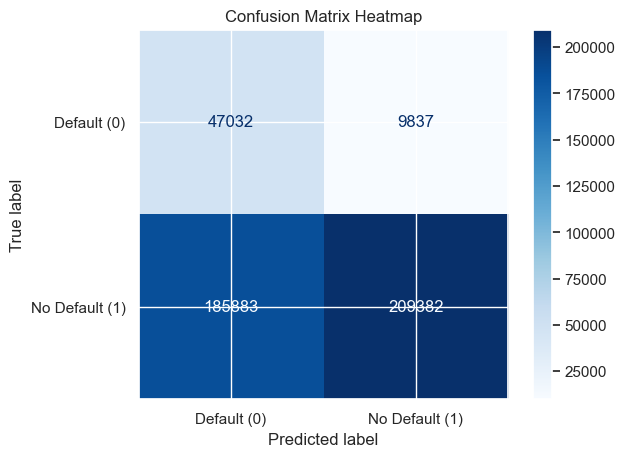

Accuracy: 0.567119482277378
Precision: 0.9551270647161059
Recall: 0.5297256271109256
F1 Score: 0.6814888589450661
Specificity: 0.8270235101725018


In [27]:
cutoff_threshold = 0.9 ## keeping high cut-off threshold of 90 %. To corrcetly identify defaults (or risky borrowers).
df_true_pred_prob['testdata_pred_class'] = np.where(df_true_pred_prob['pred_prob'] > cutoff_threshold, 1, 0)


y_test = df_true_pred_prob['testdata_true_class']
y_pred = df_true_pred_prob['testdata_pred_class']


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Default (0)", "No Default (1)"])

# Plot heatmap
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix Heatmap")
plt.show()

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Specificity:", cm[0][0]/cm[0].sum())

### Interpretation

- Recall for no-default (52.97%) → The model correctly identifies only about half of the borrowers who will not default. The main issue is that it wrongly classifies nearly half of the actual no-default borrowers as defaults. This means it is mistakenly rejecting a large number of safe borrowers, which could lead to lost lending opportunities and revenue.

- When the model predicts a borrower will **not default**, it is usually correct (Precision ~95.5%).

- The model does a good job catching most defaulters (Specificity ~82.7%), which helps reduce credit risk.

- Overall accuracy is moderate (~56.8%), reflecting the balance between catching risky borrowers and approving safe ones.

#### Business implication

The model is quite **conservative** in approving borrowers, which reduces credit risk but may lead to rejecting many good customers and potential lost business.


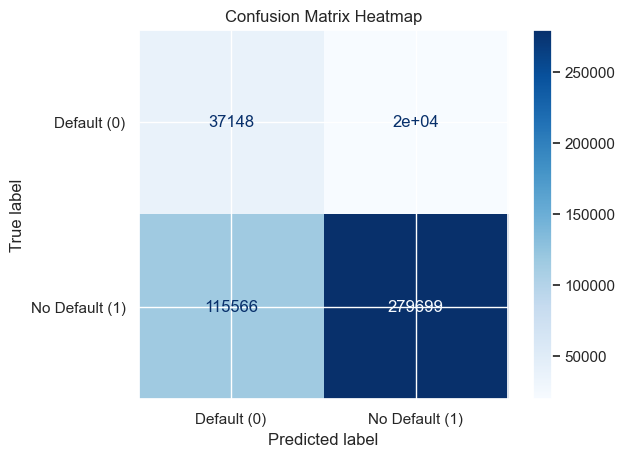

Accuracy: 0.700781184339156
Precision: 0.9341359962594349
Recall: 0.7076239990892186
F1 Score: 0.8052541799520646
Specificity: 0.653220559531555


In [28]:
cutoff_threshold = 0.85 ## keeping high cut-off threshold of 85 %. To corrcetly identify defaults (or risky borrowers).
df_true_pred_prob['testdata_pred_class'] = np.where(df_true_pred_prob['pred_prob'] > cutoff_threshold, 1, 0)


y_test = df_true_pred_prob['testdata_true_class']
y_pred = df_true_pred_prob['testdata_pred_class']


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Default (0)", "No Default (1)"])

# Plot heatmap
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix Heatmap")
plt.show()

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Specificity:", cm[0][0]/cm[0].sum())

## **ROC and AUC**

**ROC (Receiver Operating Characteristic) Curve:**  
- A graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied.  
- It plots the **True Positive Rate (Recall)** on the Y-axis against the **False Positive Rate (1 - Specificity)** on the X-axis.

**AUC (Area Under the ROC Curve):**  
- A single scalar value summarizing the overall performance of the classifier.  
- Represents the probability that the classifier ranks a randomly chosen positive instance higher than a randomly chosen negative one.  
- Values range from 0 to 1, where 0.5 means random guessing and 1.0 means perfect classification.

---
### Relationship Between ROC Curve and Confusion Matrix

- The **confusion matrix** summarizes the classification results at a **specific threshold**, showing counts of true positives, false positives, true negatives, and false negatives.

- The **ROC curve** shows how the model’s **True Positive Rate (Recall)** and **False Positive Rate** change as you vary the classification threshold.

---

**Key points:**

- Each point on the ROC curve corresponds to a different threshold and thus to a different confusion matrix.

- At one extreme threshold, the model predicts all instances as positive, resulting in high TPR and high FPR; at the other extreme, it predicts all negatives, yielding low TPR and low FPR.

- By analyzing the ROC curve, you can select the threshold that offers the best balance between TPR and FPR according to your business needs.

---

**In summary:**  
- Confusion matrix gives a snapshot of model performance at one threshold.  
- ROC curve summarizes performance across all thresholds, enabling threshold tuning and model comparison.


### When do we use ROC and AUC?

- When evaluating the **discriminative ability** of a binary classification model across all possible classification thresholds.  
- Especially useful when dealing with **imbalanced datasets**, where accuracy might be misleading.  
- To compare different models or tune the classification threshold based on the trade-off between true positives and false positives.

---

### How to interpret ROC and AUC?

- **ROC Curve:**  
  - A curve closer to the top-left corner indicates better model performance.  
  - The diagonal line from bottom-left to top-right represents random guessing.

- **AUC Score:**  
  - **Close to 1:** Excellent model with high separability between classes.  
  - **Around 0.5:** No better than random guessing.  
  - **Below 0.5:** Worse than random (possible label inversion).

**In Probability of Default (PD) modeling:**  
- A higher AUC means the model is better at distinguishing between borrowers who will default and those who won’t, regardless of the chosen threshold.

In [29]:
fpr, tpr, thresholds = roc_curve(df_true_pred_prob['testdata_true_class'], df_true_pred_prob['pred_prob'])
# Here we store each of the three arrays in a separate variable. 

Text(0.5, 1.0, 'ROC curve')

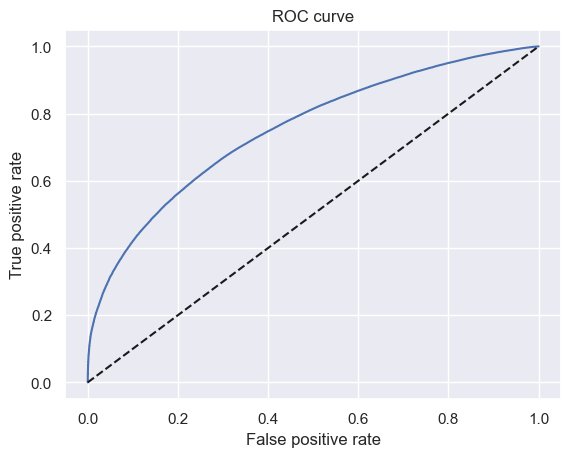

In [30]:
plt.plot(fpr, tpr)
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')
# We name the x-axis "False positive rate".
plt.ylabel('True positive rate')
# We name the x-axis "True positive rate".
plt.title('ROC curve')
# We name the graph "ROC curve".

In [31]:
AUROC = roc_auc_score(df_true_pred_prob['testdata_true_class'], df_true_pred_prob['pred_prob'])
# Calculates the Area Under the Receiver Operating Characteristic Curve (AUROC)
# from a set of actual values and their predicted probabilities.
AUROC

0.7521360768714404

### Interpretation of AUC = 0.75

An AUC (Area Under the Curve) of **0.75** indicates the model has a **good ability** to distinguish between the two classes (e.g., default vs no-default).

- The model correctly ranks a randomly chosen no-default borrower higher than a randomly chosen default borrower about 75% of the time.
- This is significantly better than random guessing (0.5) and suggests the model has useful predictive power.
- However, there is still room for improvement to reach higher accuracy.

---

**Practical takeaway:**  
- The model can effectively separate most good borrowers from risky ones.
- You may consider fine-tuning the threshold or adding features to further boost performance.


## **Gini Coefficient and Kolmogorov-Smirnov (KS) Statistic**

#### Gini Coefficient

- The **Gini coefficient** is a measure of model discriminatory power commonly used in credit scoring and probability of default (PD) models.
- It quantifies how well the model can distinguish between good (non-default) and bad (default) borrowers.
- The Gini coefficient is directly related to the AUC (Area Under the ROC Curve):

  $\text{Gini} = 2 \times \text{AUC} - 1$

- Values range from 0 (no discrimination, random model) to 1 (perfect discrimination).
- A higher Gini indicates better model performance.

---

#### Kolmogorov-Smirnov (KS) Statistic

- The **KS statistic** measures the maximum difference between the cumulative distribution functions (CDFs) of the scores for the good and bad populations.
- It shows the point where the model best separates the two classes.
- Formally:

  $\text{KS} = \max_x |F_{\text{good}}(x) - F_{\text{bad}}(x)|$

  where $F_{\text{good}}(x)$ and $F_{\text{bad}}(x)$ are the cumulative distributions of scores for good and bad borrowers, respectively.

- KS values range from 0 to 1, with higher values indicating better separation.
- Typically, a KS above 0.4 (40%) is considered a strong model in credit risk.

---

#### Summary

| Metric       | Meaning                                 | Range        | Interpretation                    |
|--------------|-----------------------------------------|--------------|---------------------------------|
| Gini         | Model’s ability to distinguish classes | 0 to 1       | Closer to 1 = better discrimination |
| KS Statistic | Max difference between good/bad CDFs   | 0 to 1       | Higher = better separation       |

Both metrics provide insights into how well your PD model ranks borrowers by risk and are widely used in model validation.

---
### How to Plot KS Statistic and Calculate Gini Coefficient

#### Step 1: Calculate Gini from AUC

The Gini coefficient is easily computed from the ROC AUC:

$\text{Gini} = 2 \times \text{AUC} - 1$

---

#### Step 2: Plot KS Statistic

The KS statistic is the maximum vertical distance between the cumulative distributions of the scores for the good and bad classes.

KS Statistic: 0.369


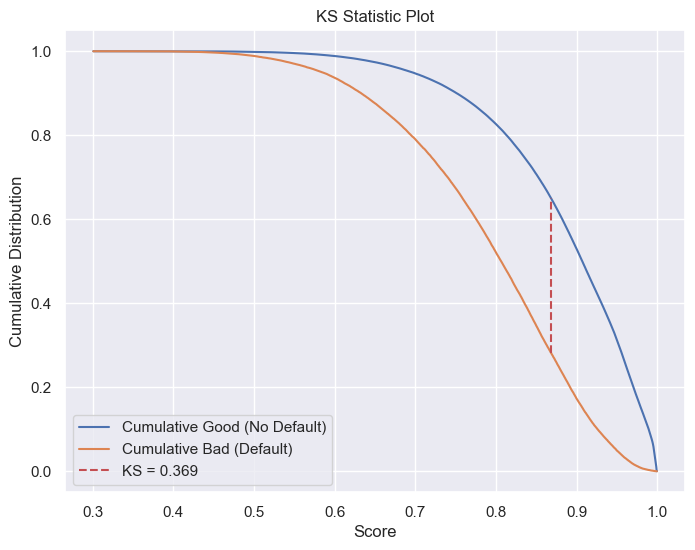

Gini Coefficient: 0.504


In [32]:
# Create a DataFrame
df = pd.DataFrame({'y_true': df_true_pred_prob['testdata_true_class'], 'y_scores': df_true_pred_prob['pred_prob']})

# Sort by score descending
df = df.sort_values(by='y_scores', ascending=False)

# Calculate cumulative distribution for good and bad
df['cum_good'] = (df['y_true'] == 1).cumsum() / (df['y_true'] == 1).sum()
df['cum_bad'] = (df['y_true'] == 0).cumsum() / (df['y_true'] == 0).sum()

# Calculate KS statistic and position
df['ks'] = df['cum_good'] - df['cum_bad']
ks_stat = df['ks'].max()
ks_pos = df['ks'].idxmax()

print(f"KS Statistic: {ks_stat:.3f}")

# Plot KS curve
plt.figure(figsize=(8,6))
plt.plot(df['y_scores'], df['cum_good'], label='Cumulative Good (No Default)')
plt.plot(df['y_scores'], df['cum_bad'], label='Cumulative Bad (Default)')
plt.vlines(df.loc[ks_pos, 'y_scores'], df.loc[ks_pos, 'cum_bad'], df.loc[ks_pos, 'cum_good'], 
           colors='r', linestyles='--', label=f'KS = {ks_stat:.3f}')
plt.xlabel('Score')
plt.ylabel('Cumulative Distribution')
plt.title('KS Statistic Plot')
plt.legend()
plt.show()

# Calculate Gini
auc = roc_auc_score(df_true_pred_prob['testdata_true_class'], df_true_pred_prob['pred_prob'])
gini = 2 * auc - 1
print(f"Gini Coefficient: {gini:.3f}")

### Interpretation of KS Statistic = 0.369

A KS (Kolmogorov-Smirnov) statistic of **0.369** means:

- The maximum difference between the cumulative distributions of the good (no-default) and bad (default) borrowers is about **36.9%**.
- This indicates a **moderate separation** between the two groups.
- Typically, a KS above 0.4 (40%) is considered strong, so 0.369 suggests the model performs reasonably well but has room for improvement.

---

**In practical terms:**  
- The model can differentiate between defaulters and non-defaulters fairly well.  
- Enhancing features or model tuning might improve this discrimination further.


### Explanation of the Step:

```python
df['cum_good'] = (df['y_true'] == 1).cumsum() / (df['y_true'] == 1).sum()
df['cum_bad'] = (df['y_true'] == 0).cumsum() / (df['y_true'] == 0).sum()
```


- (df['y_true'] == 1) creates a boolean series where True corresponds to rows with y_true = 1 (good borrowers), and False otherwise.
- (df['y_true'] == 0) creates a boolean series where True corresponds to rows with y_true = 0 (bad borrowers), and False otherwise.

- .cumsum() on this boolean series counts how many 1s or 0s have appeared up to the current row.

- (df['y_true'] == 1).sum() is the total number of 1s in the whole dataset.
- (df['y_true'] == 0).sum() is the total number of 0s in the whole dataset.

- Dividing the cumulative count by the total count normalizes it, giving the cumulative proportion of good borrowers up to each row.

## **Calculating the PD for an individual customer.**

In [33]:
pd.options.display.max_columns = None

In [34]:
len(pd_train_input.keys())

108

In [35]:
# pd_per_customer = {}

# for i in range(len(pd_train_input)):
#     # Start with intercept
#     coef = summary_table2.loc[summary_table2['Feature Names'] == 'Intercept', 'Coefficients'].iloc[0]
    
#     # Add coefficients for features active in this row
#     for var in pd_train_input.columns:
#         if pd_train_input[var][i] == 1:
#             coef += summary_table2.loc[summary_table2['Feature Names'] == var, 'Coefficients'].iloc[0]
            
#     # Logistic transformation to get PD
#     pd_value = np.exp(coef) / (np.exp(coef) + 1)
    
#     pd_per_customer[i] = pd_value

# pd_per_customer


# Fast version, without loop

# Create a mapping from feature name to coefficient
coef_map = summary_table2.set_index('Feature Names')['Coefficients']

# Start with intercept
intercept = coef_map['Intercept']

# Align coefficients with pd_train_input columns
feature_coefs = pd.Series(
    [coef_map.get(col, 0) for col in pd_test_input.columns],
    index=pd_train_input.columns
)

# Compute linear combination: intercept + sum(feature * coef)
linear_score = intercept + (pd_test_input * feature_coefs).sum(axis=1)

# Logistic transformation
pd_values = np.exp(linear_score) / (1 + np.exp(linear_score))

# Store in dictionary if you really need that format
pd_per_customer = pd_values.to_dict() 

In [36]:
list(pd_per_customer.values())[:10]

[0.8105523458034112,
 0.8975392487878451,
 0.6637471465875348,
 0.922775913089292,
 0.8933684916499016,
 0.7376746714117728,
 0.6895481753074645,
 0.906054436937307,
 0.7430633683616142,
 0.77419659195819]

### We don't need the above calculations. We directly use the predict_proba method for the probability.

In [37]:
pred_prob = reg2.model.predict_proba(pd_test_input)
pred_prob[:10]

array([[0.18944765, 0.81055235],
       [0.10246075, 0.89753925],
       [0.33625285, 0.66374715],
       [0.07722409, 0.92277591],
       [0.10663151, 0.89336849],
       [0.26232533, 0.73767467],
       [0.31045182, 0.68954818],
       [0.09394556, 0.90605444],
       [0.25693663, 0.74306337],
       [0.22580341, 0.77419659]])

## Credit Scorecards in PD Models

### 1. **What is a Credit Scorecard?**
A credit scorecard is a systematic way of transforming the results of a **Probability of Default (PD) model** into a set of points that can be used for risk assessment, decision-making, and communication with non-technical stakeholders. 

- Instead of working directly with probabilities (e.g., 0.02 or 0.35), the scorecard assigns **scores** to each borrower based on their characteristics, where a **higher score indicates lower risk** (and vice versa).

---

### 2. **Purpose of a Scorecard**
- **Interpretability:** Makes the PD model output easy to understand for credit officers, management, and regulators.
- **Standardization:** Allows the bank or lender to apply consistent decision thresholds across different products or customer segments.
- **Actionability:** Maps risk into operational rules (e.g., approve, refer, decline).
- **Comparability:** Scores can be compared across time, products, and geographies.

---

### 3. **Advantages of Scorecards**
- **Transparency:** Stakeholders can see how each factor contributes to the score.
- **Operational use:** Easy to integrate into loan origination systems.
- **Regulatory acceptance:** Widely used and accepted in banking risk modeling.

---

### 4. **Limitations**
- **Loss of probability precision:** Scores are easier to interpret but less precise than PD values.
- **Requires periodic recalibration:** Economic conditions and borrower behavior change over time.
- **Assumes additivity:** The scorecard approach is linear in log-odds, so interactions must be explicitly modeled.

---

**In summary:**  
Scorecards are a practical, interpretable, and standardized way of converting PD model outputs into credit scores.  
They bridge the gap between statistical modeling and business decision-making, ensuring that model outputs are both usable and explainable.


> **Notes:**  
> In logistic regression, one category from each categorical variable is chosen as the **reference group** and is omitted during model training (its coefficient is set to 0).
>   
> In a credit scorecard, these reference categories should still be **included in the score table** with 0 points so that the scoring process is transparent and complete.
> 
> The minimum credit assessment is reached when a borrower falls into the worst categories (lowest coefficients) for each variables.
> 
> The maximum credit assessment is reached when a borrower falls into the best categories (highest coefficients) for each variables.

In [38]:
# creating a dataframe for our reference categories, to be merged 
df_ref_categories = pd.DataFrame(ref_var_lst, columns = ['Feature Names'])
df_ref_categories['Coefficients'] = 0
df_ref_categories['p_values'] = np.nan
df_ref_categories.head()

,Feature Names,Coefficients,p_values
0,grade:G,0,NaN
1,home_ownership:Rent_Any_None_Other,0,NaN
2,addr_state:IA_AL_MS_AR_OK_LA_NV,0,NaN
3,verification_status:Verified_SourceVerified,0,NaN
4,initial_list_status:f,0,NaN


In [39]:
df_scorecard = pd.concat([summary_table2, df_ref_categories], axis=0)
df_scorecard = df_scorecard.reset_index(drop=True)
df_scorecard['Original Feature Name'] = df_scorecard['Feature Names'].str.split(':').str[0]
df_scorecard.head()

,Feature Names,Coefficients,p_values,Original Feature Name
0,Intercept,-0.961358,NaN,Intercept
1,grade:A,1.226053,1.021728e-199,grade
2,grade:B,1.027917,8.494995e-186,grade
3,grade:C,0.803986,2.829222e-139,grade
4,grade:D,0.621926,5.128737e-101,grade


## **How to built a Scorecard?**
The general steps to create a scorecard from a PD logistic regression model are:

1. **Train a logistic regression model**  
   - Dependent variable: Default (0) / Non-default (1)
   - Independent variables: Borrower characteristics (e.g., income, credit history, loan purpose).
   
2. **Derive log-odds (logit) from model coefficients**  
   - For a borrower:  
     $
     \text{Log-odds} = \beta_0 + \beta_1 x_1 + \dots + \beta_n x_n
     $
   
3. **Transform log-odds into points** using a **scaling formula**:
   $
   \text{Score} = \text{Offset} + \text{Factor} \times \text{Log-odds}
   $
   - **Offset** and **Factor** are chosen so that:
     - A specific PD corresponds to a “base score” (e.g., PD = 1% → 600 points).
     - A fixed number of points represents a doubling or halving of odds (often called “Points to Double the Odds” or PDO).
   
4. **Assign points to each attribute level**  
   - Example:  
     - Grade A: +50 points  
     - Grade B: +30 points  
     - Grade C: +10 points  
     - Grade D: 0 points (reference group)
   
5. **Sum the points** for all features for each borrower → **Final credit score**.

---

In [40]:
# Step 1: Define Scorecard parameters
min_score = 300
max_score = 850

# Step 2: Compute min/max sum of coefficients (exclude intercept)
min_sum_coef = df_scorecard.groupby('Original Feature Name')['Coefficients'].min().sum()  # sum of worst coefficient per variable. 
max_sum_coef = df_scorecard.groupby('Original Feature Name')['Coefficients'].max().sum()  # sum of best coefficient per variable. 

min_sum_coef, max_sum_coef

(np.float64(-1.4273517059471619), np.float64(9.001441013958793))

In [41]:
# Step 3: Scale coefficients to score range
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
df_scorecard.head() 

,Feature Names,Coefficients,p_values,Original Feature Name,Score - Calculation
0,Intercept,-0.961358,NaN,Intercept,-50.700696
1,grade:A,1.226053,1.021728e-199,grade,64.660305
2,grade:B,1.027917,8.494995e-186,grade,54.210906
3,grade:C,0.803986,2.829222e-139,grade,42.401108
4,grade:D,0.621926,5.128737e-101,grade,32.799504


### **Adjusting the Intercept in a Scorecard**

- The score corresponding to the **intercept** of our PD model should be close to the `min_score`, representing the **worst-case scenario**.  
If the intercept is not correctly adjusted, the base score of the PD model will not align properly with the scorecard range, causing all subsequent feature scores to be mis-scaled.

- In a **scorecard**, we must adjust this intercept so that the **total score range** matches the desired range (e.g., 300 to 850).

**Formula:**
```python
df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) /
                                          (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score


In [42]:
# Step 4: Adjust intercept to set base score correctly

df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) /
                                          (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score

df_scorecard.head()

,Feature Names,Coefficients,p_values,Original Feature Name,Score - Calculation
0,Intercept,-0.961358,NaN,Intercept,324.575845
1,grade:A,1.226053,1.021728e-199,grade,64.660305
2,grade:B,1.027917,8.494995e-186,grade,54.210906
3,grade:C,0.803986,2.829222e-139,grade,42.401108
4,grade:D,0.621926,5.128737e-101,grade,32.799504


In [43]:
(df_scorecard.groupby('Original Feature Name')['Score - Calculation'].min().sum(),
 df_scorecard.groupby('Original Feature Name')['Score - Calculation'].max().sum())

(np.float64(300.0), np.float64(850.0))

### Rounding Scores in a Scorecard

Rounding the calculated scores to whole numbers is common practice, as it makes the scorecard easier to interpret and communicate.  
However, when rounding:

- Be aware that it can slightly change the **minimum and maximum scores**.  
- To maintain consistency with your intended score range (`min_score` → `max_score`), you may need to **adjust the intercept or scale factor** slightly to compensate for the rounding effect.  

**In short:** rounding is fine, but ensure the scorecard still respects the desired range.

In [44]:
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()

(df_scorecard.groupby('Original Feature Name')['Score - Preliminary'].min().sum(),
 df_scorecard.groupby('Original Feature Name')['Score - Preliminary'].max().sum())

(np.float64(301.0), np.float64(852.0))

In [45]:
df_scorecard['Score - Preliminary'][0] = 324
(df_scorecard.groupby('Original Feature Name')['Score - Preliminary'].min().sum(),
 df_scorecard.groupby('Original Feature Name')['Score - Preliminary'].max().sum())

(np.float64(300.0), np.float64(851.0))

### Adjusting Scores After Rounding

- **Observed shift:** `min_score` increased by 1, `max_score` increased by 2.  

**Adjustment steps:**

1. **Adjust the intercept (base score):**  
   - Reduce the intercept by 1 point to bring the `min_score` back to 300.  

2. **Fine-tune the highest rounding error:**  
   - Identify the feature that contributed the most rounding difference (e.g., `annual_income`).  
   - Subtract 1 point from that feature to adjust the `max_score` back to 850.  

**Notes:**  
- Always adjust the **intercept first**, as it affects all borrowers.  
- Only adjust individual features if necessary to preserve the relative contributions and maintain interpretability.

In [46]:
df_scorecard.groupby('Original Feature Name')['Score - Preliminary'].max()

Original Feature Name
Intercept                  324.0
addr_state                  39.0
annual_inc                  12.0
dti                          9.0
emp_length_int              10.0
funded_amnt                 25.0
grade                       65.0
home_ownership              15.0
initial_list_status          1.0
inq_last_6mths              17.0
installment                 14.0
int_rate                    71.0
months_since_issue_date    209.0
mths_since_last_delinq       1.0
pub_rec                      6.0
purpose                     16.0
term_int                     6.0
total_acc                    3.0
verification_status          8.0
Name: Score - Preliminary, dtype: float64

In [47]:
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard.groupby('Original Feature Name')['Difference'].max()

Original Feature Name
Intercept                 -0.575845
addr_state                 0.325737
annual_inc                 0.490980
dti                        0.434501
emp_length_int             0.376703
funded_amnt                0.393650
grade                      0.339695
home_ownership             0.312337
initial_list_status        0.324598
inq_last_6mths             0.271400
installment                0.494035
int_rate                   0.410884
months_since_issue_date    0.351822
mths_since_last_delinq     0.375723
pub_rec                    0.413873
purpose                    0.479363
term_int                   0.441930
total_acc                  0.127920
verification_status        0.168550
Name: Difference, dtype: float64

In [48]:
df_scorecard[85:86]

,Feature Names,Coefficients,p_values,Original Feature Name,Score - Calculation,Score - Preliminary,Difference
85,annual_inc:152000-200000,0.222214,9.523494e-34,annual_inc,11.719233,12.0,0.280767


In [49]:
df_scorecard['Points'] = df_scorecard['Score - Preliminary']
df_scorecard['Points'][85] = 11
(df_scorecard.groupby('Original Feature Name')['Points'].min().sum(),
 df_scorecard.groupby('Original Feature Name')['Points'].max().sum())

(np.float64(300.0), np.float64(850.0))

### **Final Scorecard**

In [50]:
scorecard = df_scorecard[['Original Feature Name', 'Feature Names','Coefficients', 'Points']]
scorecard

,Original Feature Name,Feature Names,Coefficients,Points
0,Intercept,Intercept,-0.961358,324.0
1,grade,grade:A,1.226053,65.0
2,grade,grade:B,1.027917,54.0
3,grade,grade:C,0.803986,42.0
4,grade,grade:D,0.621926,33.0
5,grade,grade:E,0.413800,22.0
6,grade,grade:F,0.216772,11.0
7,home_ownership,home_ownership:OWN,0.139615,7.0
8,home_ownership,home_ownership:MORTGAGE,0.278499,15.0
9,addr_state,addr_state:NC_MD_MO_IN_PA_NJ,0.130836,7.0


### **Calculating Credit Score**

In [51]:
# Create a mapping from feature name to coefficient
points_map = scorecard.set_index('Feature Names')['Points']
points_map

Feature Names
Intercept                                      324.0
grade:A                                         65.0
grade:B                                         54.0
grade:C                                         42.0
grade:D                                         33.0
grade:E                                         22.0
grade:F                                         11.0
home_ownership:OWN                               7.0
home_ownership:MORTGAGE                         15.0
addr_state:NC_MD_MO_IN_PA_NJ                     7.0
addr_state:KS_WA_CT_SC_CO_ND                    22.0
addr_state:GA_WY_RI_MT_IL                       17.0
addr_state:AK_MA_DE_UT_WI                       11.0
addr_state:TN_MI_VA_KY_AZ                        8.0
addr_state:OR_NH_WV_DC                          27.0
addr_state:HI_NM_SD                              8.0
addr_state:MN_NE_OH                             10.0
addr_state:ID_VT                                33.0
addr_state:TX                   

In [52]:
# Start with intercept
intercept = points_map['Intercept']
intercept

np.float64(324.0)

In [53]:
# Align points with test_var columns (with ref categories)
feature_points = pd.Series(
    [points_map.get(col, 0) for col in test_var.columns],
    index=test_var.columns)
# Compute linear combination: intercept + sum(feature * coef)
credit_score = intercept + (test_var * feature_points).sum(axis=1)
credit_score[:10]

0    450.0
1    492.0
2    412.0
3    507.0
4    488.0
5    429.0
6    419.0
7    495.0
8    432.0
9    441.0
dtype: float64

In [54]:
# verifying results, first 10 rows

for i in range(10):
    # Get column names where value is 1
    active_columns = test_var.columns[test_var.iloc[i] == 1].tolist()
    cr = points_map['Intercept']
    for cc in active_columns:
        cr+= points_map[cc]
    print(cr)

450.0
492.0
412.0
507.0
488.0
429.0
419.0
495.0
432.0
441.0


### Setting the Cutoff for Borrower Classification

In credit risk modeling, we often need to decide a **threshold** (cutoff) to classify borrowers as likely to **default** or **not default**. This cutoff can be determined using **Probability of Default (PD)**, **Scorecards**, or **ROC curves**.

---

#### 1. Using Probability of Default (PD)
- The PD is the probability that a borrower will default.
- A common starting point is a **50% cutoff**:  
  - `PD < 0.5` → classify as **default**  
  - `PD >= 0.5` → classify as **no default**
- You can **adjust the cutoff** based on business goals:  
  - Higher cutoff→ more borrowers classified as default (more conservative)  
  - Lower cutoff → fewer borrowers classified as default (less conservative)

---

#### 2. Using Scorecards
- Credit scores are a **transformed version of PD**, scaled to a readable range (e.g., 300–850).  

- Borrowers with scores below the cutoff are classified as higher risk.

---

#### 3. Using ROC Curve
- The **ROC curve** plots **True Positive Rate (Recall)** vs **False Positive Rate** at all possible thresholds.
- Choose a cutoff that **balances sensitivity and specificity**:
  - **High threshold** → fewer false positives, but may miss some defaults (lower recall)
  - **Low threshold** → catch more defaults, but more false positives
- The **optimal cutoff** is often chosen as the point **closest to the top-left corner** of the ROC plot or where business metrics are optimized.

---

**Key Idea:**  
The cutoff is not fixed at 50% PD or a fixed score. It depends on the **business risk appetite**, **cost of false positives**, and **cost of false negatives**. ROC curve analysis helps to choose a threshold that **optimally balances risk and opportunity**.
